In [2]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

https://kartoweb.itc.nl/geometrics/Coordinate%20transformations/coordtrans.html

In [3]:
initial_image_png = "cropped_image.png"
points = np.genfromtxt('points.csv', delimiter=',', names=True)

# convert points to float tuples
points = [(float(x), float(y)) for x, y in points]
points = np.array(points)

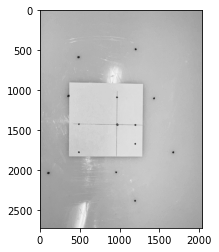

In [4]:
img = cv.imread(initial_image_png, cv.IMREAD_GRAYSCALE)

plt.imshow(img, cmap="gray")

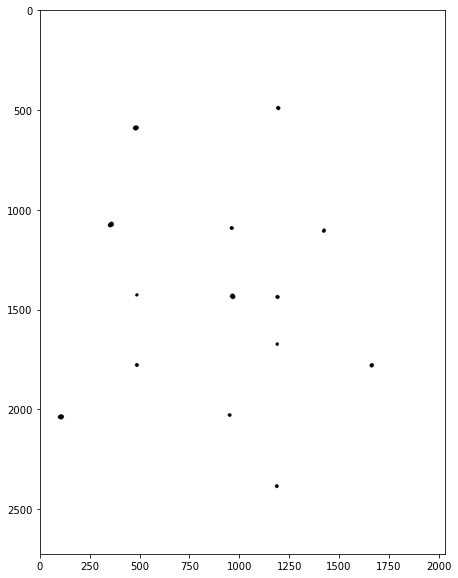

In [5]:
thresh, bwImage = cv.threshold(img, 100, 255, cv.THRESH_BINARY)
# set the height of the plot to 10 inches

bwImage = cv.medianBlur(bwImage, 15)


plt.figure(figsize=(10, 10))
plt.imshow(bwImage, cmap="gray")

In [6]:
params = cv.SimpleBlobDetector_Params()
params.minThreshold = 10
params.maxThreshold = 50

# params.filterByArea = True
params.minArea = 10

# # Filter by Circularity
params.filterByCircularity = True
params.minCircularity = 0.1

# # Filter by Convexity
params.filterByConvexity = True
params.minConvexity = 0.87

# # Filter by Inertia
params.filterByInertia = True
params.minInertiaRatio = 0.1


detector = cv.SimpleBlobDetector_create(params)
keypoints = detector.detect(bwImage)
len(keypoints)

14

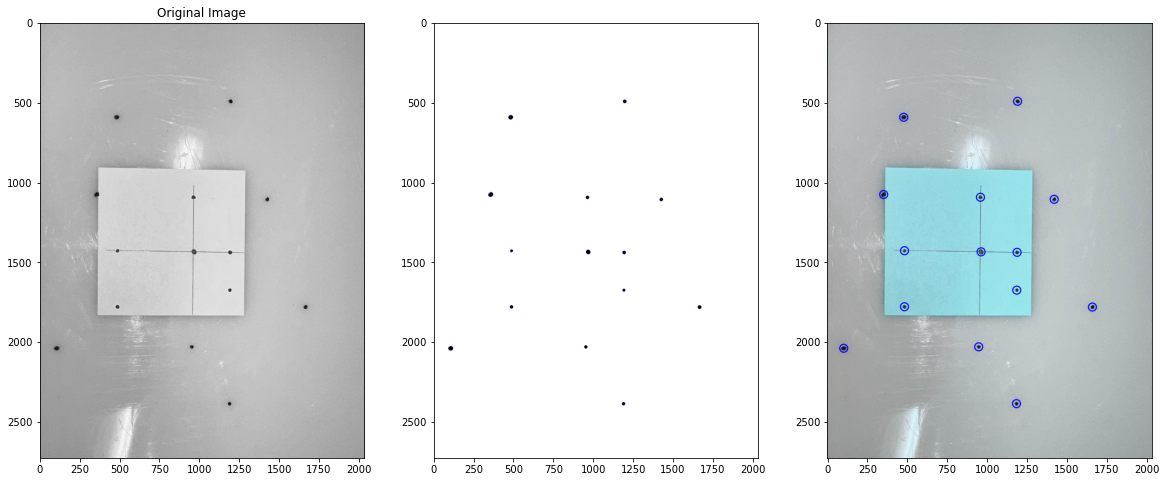

In [7]:
im_with_keypoints = cv.drawKeypoints(bwImage, keypoints, np.array([]), (0,0,255), cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
circleImg = np.ones((bwImage.shape)) * 255
found_point_centers = []

for i, keypoint in enumerate(keypoints):
    center = (int(keypoint.pt[0]), int(keypoint.pt[1]))
    found_point_centers.append(center)
    cv.circle(circleImg, center, 25, 0, -1)

colored_img = cv.imread(initial_image_png, cv.IMREAD_COLOR)

# Draw a circle around each found point with 25% transparency
for i, found_point in enumerate(found_point_centers):
    cv.circle(colored_img, found_point, 25, (0, 0, 255, 10), 5)

plt.subplots(1, 3, figsize=(20, 8))

plt.subplot(1, 3, 1)
plt.imshow(img, cmap="gray")
plt.title("Original Image")

plt.subplot(1, 3, 2)
plt.imshow(im_with_keypoints)

plt.subplot(1, 3, 3)
plt.imshow(colored_img)


We now need to map each found point to one of the points in points 
# This is the part that should be rewritten! this way is really hacky and can't honestly be trusted

Text(0.5, 1.0, 'Rotated Image')

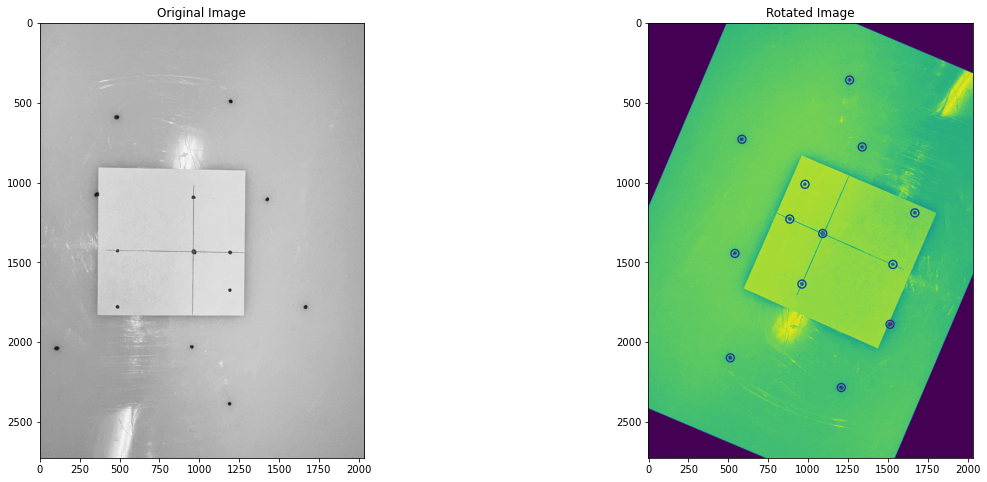

In [13]:
# Map each point to the closest found point, knowing that points may be in different order
# and that the image is likely to be rotated and perspective distorted

def get_transformation_mat(center_coords, angle):
    #  Get the transformation matrix for the given angle
    #  The transformation matrix is used to rotate the image or points
    #  around the center of the image
    #  The angle is in degrees

    trans_mat = cv.getRotationMatrix2D(center_coords, angle, 1.0)
    return trans_mat

def rotate_objects(image, coords1, angle):
    # get transformation matrix to rotate image 90 degrees
    mat = get_transformation_mat((img.shape[1] / 2, img.shape[0] / 2), angle)

    # rotate image, expanding the canvas to fit the rotated image
    rotated_image = cv.warpAffine(image, mat, (image.shape[1], image.shape[0]))

    # expand the coordinates to match the shape of the rotated image
    coords1 = np.expand_dims(coords1, axis=1)

    # rotate points
    rotated_coords1 = cv.transform(coords1, mat)
    return rotated_image, rotated_coords1

def perform_basic_matching(points0, points1):
    # sort points by x coordinate, then by y coordinate, such that 
    # when traversing the points, the first point is the top left point 
    # and the last point is the bottom right point
    points0 = points0[np.lexsort((points0[:, 1], points0[:, 0]))]
    points1 = points1[np.lexsort((points1[:, 1], points1[:, 0]))]

    return zip(points0, points1)

# compute the distance from each known point to each point
# found in the image
known_distances = np.zeros((len(points), len(points)))
for i, known_point in enumerate(points):
    for j, found_point in enumerate(found_point_centers):
        known_distances[i, j] = np.linalg.norm(known_point - found_point)

known_distances_norm = known_distances / np.max(known_distances)
min_error = np.inf
best_mapping = None
best_rot_points = None
best_rot_img = None
best_rot_angle = None

for angle in range(0, 360):
    rot_img, rot_points = rotate_objects(img, found_point_centers, angle)

    # remove usesless dimension
    rot_points = np.squeeze(rot_points)

    # Add ids to the points so that we can match them later
    # rot_points = np.array([(int(x), int(y), i) for i, (x, y) in enumerate(rot_points)])
    
    initial_mapping = perform_basic_matching(points, rot_points)
    
    # calculate the error for mapping the known points to the found points

    # calibrate the normalized distance matrix for the found points
    found_distances = np.zeros((len(rot_points), len(rot_points)))
    for i, point in enumerate(rot_points):
        for j, other_point in enumerate(rot_points):
            found_distances[i, j] = np.linalg.norm(point - other_point)

    found_distances_norm = found_distances / np.max(found_distances)

    # calculate the error for mapping the known points to the found points
    error = np.sum(np.abs(known_distances_norm - found_distances_norm))

    if error < min_error:
        min_error = error
        best_mapping = initial_mapping
        best_rot_points = rot_points
        best_rot_img = rot_img
        best_rot_angle = angle

# Draw the circles on the best rotated image
for i, found_point in enumerate(best_rot_points):
    cv.circle(best_rot_img, found_point, 25, (0, 0, 255, 10), 5)

plt.subplots(1, 2, figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.imshow(img, cmap="gray")
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(best_rot_img)
plt.title("Rotated Image")


In [17]:
mapping = {}

# Reverse the rotation so we can map the original found points to the points
rot_mat = get_transformation_mat((img.shape[1] / 2, img.shape[0] / 2), -best_rot_angle)

for i, (known_point, found_point) in enumerate(best_mapping):
    found_point = np.dot(rot_mat, np.array([found_point[0], found_point[1], 1]))

    found_point = (int(found_point[0]), int(found_point[1]))
    mapping[found_point] = known_point

# for i, (known_point, found_point) in enumerate(best_mapping):
#     # convert the points to tupls
#     known_point = tuple(known_point)
#     found_point = tuple(found_point)
#     mapping[found_point] = known_point

best_mapping

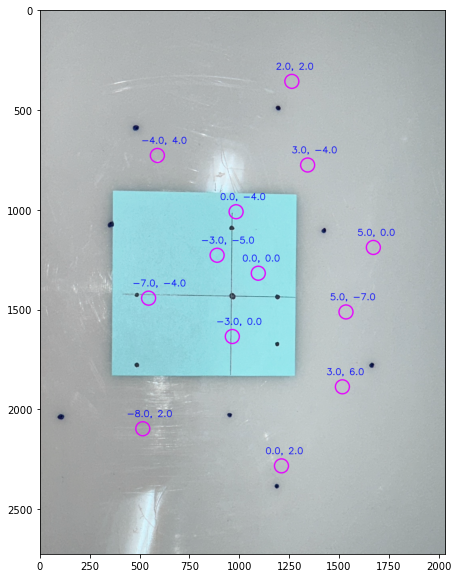

In [14]:
color_img = cv.imread(initial_image_png, cv.IMREAD_COLOR)


for found_coord, original_coord in mapping.items():
    text = f"{original_coord[0]}, {original_coord[1]}"

    text_point = (int(found_coord[0] - 80), int(found_coord[1] - 60))

    cv.putText(color_img, text, text_point, cv.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 255), 2, cv.LINE_AA)

    cv.circle(color_img, found_coord, 35, (230, 0, 255, 10), 5)

# make image size 10 inches by 10 inches
plt.figure(figsize=(10, 10))
plt.imshow(color_img)